### Using the preprocess module, attempting to get training up and running using PyTorch

In [21]:
import preprocess
import torch
import torchvision
import rasterio.features
from torch.utils.data import DataLoader
from torchvision import models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torch import nn
import torch.optim as optim
import copy
from tqdm import tqdm
import time
from sklearn.metrics import roc_auc_score, f1_score
import numpy as np

import segmentation_models_pytorch as smp

In [7]:
### just need to load up the model, setup the parameters, start iterating
### source: https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/

In [13]:
def createDeepLabv3(outputchannels=1):
#     model = torchvision.models.resnet50(pretrained=False)
#     print(model.conv1)
#     # https://discuss.pytorch.org/t/how-to-transfer-the-pretrained-weights-for-a-standard-resnet50-to-a-4-channel/52252
#     weight = model.conv1.weight.clone()
#     model.conv1 = nn.Conv2d(4, 256, kernel_size=7, stride=2, padding=3, bias=False)
#     with torch.no_grad():
#         model.conv1.weight[:, :3] = weight
#         model.conv1.weight[:, 3] = model.conv1.weight[:, 0]
#     # Adding a sigmoid activation after last convolution because we want to output pria value between 0 and 1
#     model.classifier = DeepLabHead(2048, outputchannels)
    model = smp.Unet(classes=1, in_channels=4)
    # set the model into training mode and return
    model.train()
    return model

In [14]:
torch.cuda.is_available()

True

In [37]:
# now need to define training procedure
def train_model(model, criterion, dataloader, optimizer, metrics, num_epochs=3):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use GPU if available
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # initialize log
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    
    # Training
    for epoch in range(1, num_epochs + 1):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print("-"*10)
        batchsummary = {a: [0] for a in fieldnames}
        # Each epoch has training and validation
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            # Begin iterating over data using batches
            for sample in tqdm(iter(dataloader)):
                inputs = sample['image'].to(device)
                masks = sample['mask'].float().to(device)
                masks = masks.unsqueeze(1)
                # zero parameter gradients
                optimizer.zero_grad()
                # track the history if we're in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # use classification threshold of 0.1
                            try:
                                batchsummary[f'{phase}_{name}'].append(metric(y_true > 0, y_pred > 0.1))
                            except:
                                batchsummary[f'{phase}_{name}'] = [metric(y_true > 0, y_pred > 0.1)]
                        else:
                            try:
                                batchsummary[f'{phase}_{name}'].append(metric(y_true.astype('uint8'),y_pred))
                            except:
                                batchsummary[f'{phase}_{name}']= [metric(y_true.astype('uint8'),y_pred)]
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
            for field in fieldnames[3:]:
                batchsummary[field] = np.mean(batchsummary[field])
            print(batchsummary)
            if phase == 'test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Lowest Loss: {:4f}'.format(best_loss))
    model.load_state_dict(best_model_wts)
    return model 

In [16]:
model = createDeepLabv3()
criterion = torch.nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=1e-4)
metrics = {'f1_score':f1_score, 'auroc':roc_auc_score}

In [17]:
twelve_img = "/vol/ml/EphemeralStreamData/Ephemeral_Channels/Imagery/vhr_2012_refl.img"
twelve_shp = "/vol/ml/EphemeralStreamData/Ephemeral_Channels/Reference/reference_2012_merge.shp"

In [18]:
ds = preprocess.GISDataset([(twelve_img, twelve_shp)])

/homes/mzvyagin/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [19]:
dataloader = DataLoader(ds, batch_size = 50)

In [24]:
trained_model = train_model(model, criterion, dataloader, optimizer, metrics)

  0%|          | 0/237 [00:00<?, ?it/s]

Epoch 1/3
----------


  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.1153
{'epoch': 1, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4307045668390206, 0.2576728408537507, 0.31272331201711445, 0.2870130965735497, 0.3081785300611247, 0.41083446930413164, 0.43054482756050566, 0.3898744174418083, 0.3423676158799798, 0.3556860776430398, 0.5224778667669238, 0.3726837370242215, 0.40744982643171374, 0.33417898183772615, 0.43179639597737984, 0.4783605137767679, 0.29346661405995234, 0.3089228021639649, 0.2580501083848599, 0.37098200165225703, 0.4953032915427951, 0.3869786547794733, 0.47701070258914424, 0.34428623367269756, 0.43488774076286324, 0.3968330776532284, 0.5111968449832737, 0.430292963409252, 0.376598184064117, 0.40808040742904156, 0.4070358219955098, 0.502423913095063, 0.3576959200379131, 0.3859134168529467, 0.4781885290882257, 0.5435269256387052, 0.5712670490879526, 0.3744086668840247, 0.47327593950572494, 0.49695347749006946, 0.538945984367055

  0%|          | 0/237 [00:00<?, ?it/s]

test Loss: 0.1974
{'epoch': 1, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4307045668390206, 0.2576728408537507, 0.31272331201711445, 0.2870130965735497, 0.3081785300611247, 0.41083446930413164, 0.43054482756050566, 0.3898744174418083, 0.3423676158799798, 0.3556860776430398, 0.5224778667669238, 0.3726837370242215, 0.40744982643171374, 0.33417898183772615, 0.43179639597737984, 0.4783605137767679, 0.29346661405995234, 0.3089228021639649, 0.2580501083848599, 0.37098200165225703, 0.4953032915427951, 0.3869786547794733, 0.47701070258914424, 0.34428623367269756, 0.43488774076286324, 0.3968330776532284, 0.5111968449832737, 0.430292963409252, 0.376598184064117, 0.40808040742904156, 0.4070358219955098, 0.502423913095063, 0.3576959200379131, 0.3859134168529467, 0.4781885290882257, 0.5435269256387052, 0.5712670490879526, 0.3744086668840247, 0.47327593950572494, 0.49695347749006946, 0.5389459843670555

  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.1074
{'epoch': 2, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4260941390001477, 0.24770126355272054, 0.3089801402115543, 0.2926640256308103, 0.31325539396114493, 0.4216353291098262, 0.441127014460116, 0.4370904500559402, 0.36920106935584457, 0.4018558355989645, 0.5208899023073865, 0.3917245727916753, 0.4466479787626203, 0.3541472797538867, 0.43997814181030076, 0.5040640962448316, 0.3142463241187824, 0.3389508142875272, 0.2673782821170158, 0.3905773616093257, 0.5042371414817199, 0.417359472695673, 0.5137308845806592, 0.3296663206488049, 0.45927845647929166, 0.41862210301761854, 0.5513838982962675, 0.4537331741926928, 0.3873401595931592, 0.4166969998866452, 0.5302465529827125, 0.5261918103211488, 0.3947813753574797, 0.3750599092943576, 0.48760624337445607, 0.5423431375326339, 0.580707508456221, 0.3882384093593188, 0.499060595929751, 0.5015929108584071, 0.5255012200116925, 0.483

  0%|          | 0/237 [00:00<?, ?it/s]

test Loss: 0.3387
{'epoch': 2, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4260941390001477, 0.24770126355272054, 0.3089801402115543, 0.2926640256308103, 0.31325539396114493, 0.4216353291098262, 0.441127014460116, 0.4370904500559402, 0.36920106935584457, 0.4018558355989645, 0.5208899023073865, 0.3917245727916753, 0.4466479787626203, 0.3541472797538867, 0.43997814181030076, 0.5040640962448316, 0.3142463241187824, 0.3389508142875272, 0.2673782821170158, 0.3905773616093257, 0.5042371414817199, 0.417359472695673, 0.5137308845806592, 0.3296663206488049, 0.45927845647929166, 0.41862210301761854, 0.5513838982962675, 0.4537331741926928, 0.3873401595931592, 0.4166969998866452, 0.5302465529827125, 0.5261918103211488, 0.3947813753574797, 0.3750599092943576, 0.48760624337445607, 0.5423431375326339, 0.580707508456221, 0.3882384093593188, 0.499060595929751, 0.5015929108584071, 0.5255012200116925, 0.4833

  0%|          | 0/237 [00:00<?, ?it/s]

train Loss: 0.0697
{'epoch': 3, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4213819346617645, 0.2411619441839533, 0.3165054432362198, 0.31260145075028867, 0.3931334816864901, 0.478156123692865, 0.45663900915986966, 0.5218661449898444, 0.3965810692867362, 0.38858065666673275, 0.5313787568118197, 0.39254002354140477, 0.4620509584669943, 0.35742515330448915, 0.4492219630344464, 0.4966917119198823, 0.3102572894560439, 0.3298682776410178, 0.2795650511138174, 0.3976987345571312, 0.5060059803682316, 0.4877917854576853, 0.5869634485959108, 0.3675586265511033, 0.47131081206689696, 0.4393309271224539, 0.5941773133854068, 0.47955448969981934, 0.40791535370857596, 0.4211970273997437, 0.5260970052585316, 0.5049321112537207, 0.400152432388796, 0.36917485264587463, 0.47931517171919164, 0.4973642378594315, 0.5675641104742242, 0.4036959401542897, 0.5069122508369827, 0.47647099768590884, 0.5515994312096056,

100%|██████████| 237/237 [08:27<00:00,  2.14s/it]

test Loss: 0.3628
{'epoch': 3, 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'train_f1_score': [0.4213819346617645, 0.2411619441839533, 0.3165054432362198, 0.31260145075028867, 0.3931334816864901, 0.478156123692865, 0.45663900915986966, 0.5218661449898444, 0.3965810692867362, 0.38858065666673275, 0.5313787568118197, 0.39254002354140477, 0.4620509584669943, 0.35742515330448915, 0.4492219630344464, 0.4966917119198823, 0.3102572894560439, 0.3298682776410178, 0.2795650511138174, 0.3976987345571312, 0.5060059803682316, 0.4877917854576853, 0.5869634485959108, 0.3675586265511033, 0.47131081206689696, 0.4393309271224539, 0.5941773133854068, 0.47955448969981934, 0.40791535370857596, 0.4211970273997437, 0.5260970052585316, 0.5049321112537207, 0.400152432388796, 0.36917485264587463, 0.47931517171919164, 0.4973642378594315, 0.5675641104742242, 0.4036959401542897, 0.5069122508369827, 0.47647099768590884, 0.5515994312096056, 

In [40]:
torch.save(trained_model.state_dict(), 'vanilla_unet_params.ckpt')

In [38]:
def eval_model(trained_model, dataloader, criterion, metrics):
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    model.to(device)
    # initialize log
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    batchsummary = {a: [0] for a in fieldnames}
    model.eval()
    # run through the batches
    for sample in tqdm(iter(dataloader)):
        inputs = sample['image'].to(device)
        masks = sample['mask'].float().to(device)
        masks = masks.unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        y_pred = outputs.data.cpu().numpy().ravel()
        y_true = masks.data.cpu().numpy().ravel()
        for name, metric in metrics.items():
            if name == 'f1_score':
                # use classification threshold of 0.1
                try:
                    batchsummary[f'{name}'].append(metric(y_true > 0, y_pred > 0.1))
                except:
                    batchsummary[f'{name}'] = [metric(y_true > 0, y_pred > 0.1)]
            else:
                pass
#                 try:
#                     batchsummary[f'{name}'].append(metric(y_true.astype('uint8'),y_pred))
#                 except:
#                     batchsummary[f'{name}']= [metric(y_true.astype('uint8'),y_pred)]
    # write out the results
    print('Loss: {:.4f}'.format(loss))
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
    print(batchsummary)

In [27]:
fourteen_img = "/vol/ml/EphemeralStreamData/Ephemeral_Channels/Imagery/vhr_2014_refl.img"
fourteen_shp = "/vol/ml/EphemeralStreamData/Ephemeral_Channels/Reference/reference_2014_merge.shp"
fourteen = preprocess.GISDataset([(fourteen_img, fourteen_shp)])
fourten_dl = DataLoader(fourteen)

/homes/mzvyagin/anaconda3/envs/gis/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


This model isn't doing very well because at certain points it's giving great results and then at other points it's giving terrible results. Clearly not robust enough, potentially overfitted?

In [39]:
eval_model(trained_model, fourten_dl, criterion, metrics)

100%|██████████| 5676/5676 [02:43<00:00, 34.77it/s]

Loss: 0.0138
{'epoch': [0], 'Train_loss': [0], 'Test_loss': [0], 'Train_f1_score': 0.0, 'Train_auroc': 0.0, 'Test_f1_score': 0.0, 'Test_auroc': 0.0, 'f1_score': [0.0, 0.0, 0.05365413297747076, 0.3183405216676936, 0.06603601964708022, 0.45151371807000945, 0.3857469332002416, 0.4330784398595681, 0.408891052161921, 0.4378156842593404, 0.37814144542579303, 0.6013665964477047, 0.34162541831554033, 0.7204443837007244, 0.2633614011451667, 0.569229761592874, 0.02064733854885719, 0.4701762577331622, 0.23967335828513103, 0.39615690594210884, 0.0, 0.467284886522572, 0.12584777694046723, 0.24954927282682726, 0.0, 0.4164220039387679, 0.0, 0.418013494429625, 0.14110238007432413, 0.5286755048662484, 0.0462864368428058, 0.4588279988602906, 0.0, 0.5039592256949299, 0.0, 0.4987932646028933, 0.0, 0.3568204613841525, 0.012073960592776859, 0.3070502965077971, 0.05517780853240267, 0.055212538589408694, 0.0, 0.0, 0.0, 0.02789983747667489, 0.08642871047089842, 0.4952929831006613, 0.03496618835559954, 0.273972

In [42]:
from rasterio.plot import show

In [44]:
sample = fourteen.__getitem__(1000)

In [59]:
trained_model.train()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [74]:
trained_model.to(torch.device('cuda:2'))

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [79]:
test_input = torch.cuda.FloatTensor(sample['image'].unsqueeze(0).cuda(device=2))

In [81]:
output=trained_model(test_input)

In [102]:
output.cpu().detach().numpy()

array([[[[ 7.86414742e-02, -2.22416781e-02,  1.11953884e-01,
           3.13291013e-01,  2.64132768e-01,  1.47982627e-01,
           3.09052229e-01,  2.42774859e-01,  2.30674297e-01,
           2.09787071e-01,  1.14514276e-01,  1.42191201e-01,
           1.08036652e-01,  1.00006953e-01,  2.12988079e-01,
           2.14684531e-01,  2.60977000e-01,  3.07810277e-01,
           3.63235146e-01,  3.81665349e-01,  4.12175387e-01,
           4.36645389e-01,  4.25938308e-01,  4.43750411e-01,
           4.47595984e-01,  4.45984751e-01,  4.46929127e-01,
           4.39558327e-01,  4.43121433e-01,  4.23947334e-01,
           4.20396119e-01,  4.24216956e-01,  4.35946405e-01,
           4.42481875e-01,  4.47610319e-01,  4.36785579e-01,
           4.49520856e-01,  4.63812858e-01,  4.76994127e-01,
           4.95846331e-01,  4.88924056e-01,  4.83227700e-01,
           4.88943189e-01,  4.69168186e-01,  4.78004694e-01,
           4.63696897e-01,  4.87419158e-01,  4.77306426e-01,
           4.91623998e-0

In [97]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.ndarray.astype((output.cpu().detach().numpy()), int)

array([[[[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
           0,  0,  0

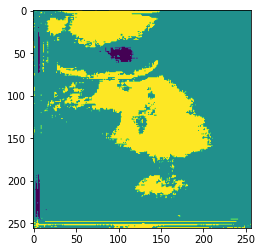

<AxesSubplot:>

In [103]:
show(np.rint(output.cpu().detach().numpy()))

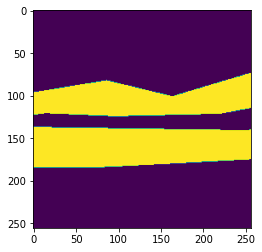

<AxesSubplot:>

In [98]:
show(sample['mask'])

### Want to try using binary cross entropy loss instead of mean-squared-error since we're doing binary classification